# Michał Szczurek Laboratrium 4.

### 0. Zaimportowanie bibliotek i zaimplementowanie uniwersalnej funkcji rysującej wykresy

In [36]:
from sympy import *
from sympy.abc import x
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.integrate import quad
from functools import lru_cache

In [41]:
def plot_res(func, res, title, k = None):
    x_vector = np.linspace(-1,1, 1000)
    func_vector = [func.replace(x,val) for val in x_vector]
    res_vector = [res(val) for val in x_vector]
    plt.plot(x_vector,  func_vector, label = "Funcja aproksymowana")
    plt.plot(x_vector, res_vector, label = "Funkcja aproksymująca", color = "red")
    if k is not None:
        points_x = np.linspace(-1,1, k)
        points_y = [func.replace(x,val) for val in points_x]
        plt.scatter(points_x, points_y, label = "Punkty aproksymacji", color="black")
    plt.legend(bbox_to_anchor=(0.47, -0.1))   
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid()
    plt.title(title,loc='left')
    plt.show()

### 1. Aproksymacja punktowa

a) Wykorzystując zmienne pomocnicze

In [42]:
def approx_1a(func, k, deg):
    
    def S_k(k, x_vals):
        return np.sum(x_vals ** k)

    def T_k(k, x_vals, y_vals):
        return np.sum(y_vals * x_vals ** k)
    
    
    x_vals = np.linspace(-1,1,k)
    y_vals = np.array([func.replace(x,v) for v in x_vals])
    
    S_vector = [S_k(i, x_vals) for i in range(2*deg + 1)]
    T_vector = np.array([T_k(i, x_vals, y_vals) for i in range(deg + 1)], dtype='float').reshape(-1,1)
    
    matrix = np.empty((deg+1, deg+1), dtype='float')
    
    for i in range(deg+1):
        matrix[i] = S_vector[i:i+deg+1]

    a_vector = np.linalg.solve(matrix, T_vector)
    a_vector = np.ndarray.flatten(np.flip(a_vector))
    poly = Poly.from_list(a_vector, gens=x).as_expr()
    
    return poly, lambdify(x, poly)

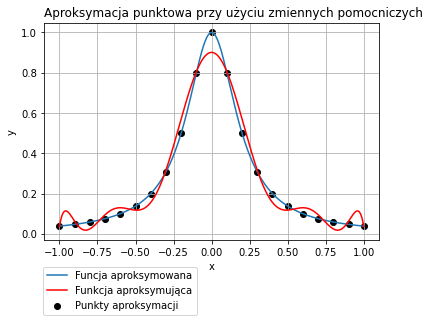

Wielomian:
-36.4579556548542*x**10 + 6.22861947755465e-10*x**9 + 100.556470409109*x**8 - 1.38560639775138e-9*x**7 - 102.262813305657*x**6 + 1.01775183401526e-9*x**5 + 47.2939064629941*x**4 - 2.74073260072607e-10*x**3 - 9.9947761267465*x**2 + 1.97222742525718e-11*x + 0.901225557361062


In [44]:
func = 1/(1+25*x**2)
res, poly = approx_1a(func, 21, 10)
plot_res(func, poly, "Aproksymacja punktowa przy użyciu zmiennych pomocniczych", 21)
print("Wielomian:")
print(res)

b) rozwiązując równanie normlne

In [43]:
def approx_1b(func, k, deg):
    x_vals = np.linspace(-1,1,k)
    y_vals = np.array([func.replace(x,v) for v in x_vals], dtype='float')
    
    matrix = np.empty((k, deg+1), dtype='float')  
    for i in range(deg+1):
        matrix[:, i] = x_vals**i 
 
    a_vector = np.linalg.solve(matrix.T @ matrix, matrix.T @ y_vals)
    a_vector = np.ndarray.flatten(np.flip(a_vector))
    poly = Poly.from_list(a_vector, gens=x).as_expr()
    
    return poly, lambdify(x, poly)

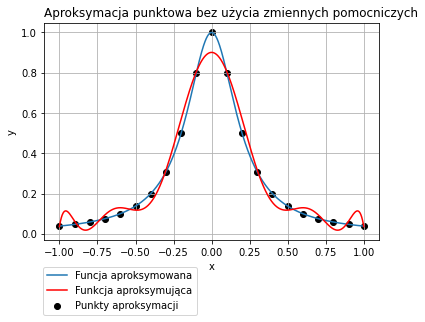

Wielomian:
-36.4579556530494*x**10 - 1.45820867603967e-10*x**9 + 100.556470404653*x**8 + 3.30341322396876e-10*x**7 - 102.262813301834*x**6 - 2.48909536082962e-10*x**5 + 47.2939064616639*x**4 + 6.96076666467273e-11*x**3 - 9.99477612658582*x**2 - 5.32275086164647e-12*x + 0.901225557358008


In [45]:
func = 1/(1+25*x**2)
res, poly = approx_1b(func, 21, 10)
plot_res(func, poly, "Aproksymacja punktowa bez użycia zmiennych pomocniczych", 21)
print("Wielomian:")
print(res)

### 2. Aproksymacja ciągła używając wielomianów w bazie naturalnej

In [46]:
def approx_2(func, deg):
    matrix = np.empty((deg+1, deg+1), dtype='float') 
    for i in range (deg+1):
        for j in range(deg+1):
            if (i+j)%2 == 0:
                matrix[i][j] = 2 / (i + j + 1)
            else:
                matrix[i][j] = 0
    
    def integral(f, k):
        # <f, Φ(k)>
        return quad(lambdify(x, f * x**k), -1, 1)[0]
    
    res_vector = np.array([integral(func, i) for i in range(deg+1)], dtype='float').reshape(-1,1) 
    c_vector = np.linalg.solve(matrix, res_vector)
    c_vector = np.ndarray.flatten(c_vector)
    res = 0
    for i in range(deg + 1):
        res += c_vector[i] * x**i
        
    return simplify(res), lambdify(x, res)

-35.9306585838445*x**10 + 98.4908412136889*x**8 - 100.076571783756*x**6 + 46.4653180765088*x**4 - 9.89447449043296*x**2 + 0.899424519631257


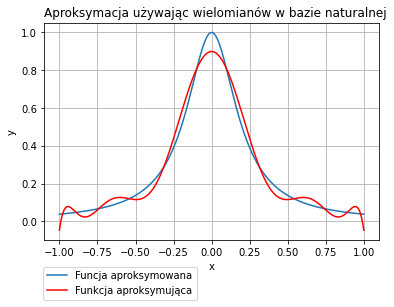

In [57]:
func = 1/(1+25*x**2)
res, poly = approx_2(func, 10)
print(res)
plot_res(func, poly, "Aproksymacja używając wielomianów w bazie naturalnej")

### 3. Aproksymacja ciągła używając wielomianów Legendre'a

In [55]:
def approx_3(func, deg):
    
    @lru_cache(maxsize=None)
    def Legendre(n):
        if n == 0:
            return 1

        if n == 1:
            return x

        return (2*n - 1)/n * x * Legendre(n-1) - (n - 1)/n * Legendre(n-2)
    
    def c_k(k, f):
        # korzystając z otogonalności
        # <Φ(k), Φ(k)> = 2 / (2k + 1)
        # <f, Φ(k)> - trzeba policzyć

        return (2*k+1)/2 * quad(lambdify(x, f * Legendre(k)), -1, 1)[0]
    

    res = 0
    for i in range(deg + 1):
        res += c_k(i, func) *  Legendre(i)
        
    return simplify(res), lambdify(x, res)

-35.9306481960538*x**10 + 98.4908166109721*x**8 - 100.076551522629*x**6 + 46.4653113227652*x**4 - 9.89447371114787*x**2 + 0.899424505462177


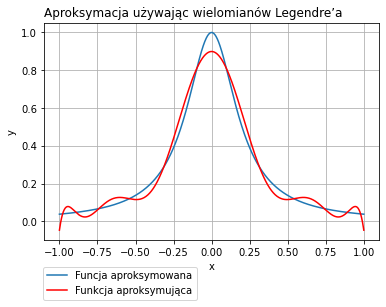

In [56]:
res, poly = approx_3(func, 10)
print(res)
plot_res(func, poly, "Aproksymacja używając wielomianów Legendre’a")

### 4. Aproksymacja ciągła używając wielomianów Chebyshev'a

In [50]:
def approx_4(func, deg):
    
    @lru_cache(maxsize=None)
    def Chebyshev(n):
        if n == 0:
            return 1

        if n == 1:
            return x

        return 2 * x * Chebyshev(n-1) -  Chebyshev(n-2)
    
    def c_k(k, f):
        # korzystając z otogonalności
        # <Φ(k), Φ(k)> = π/2 , k != 0
        # <Φ(k), Φ(k)> = π , k = 0
        # <f, Φ(k)> - trzeba policzyć
        
        factor = math.pi
        if k!=0:
            factor /= 2
            
        w = 1/sqrt(1 - x**2)
    
        return 1/factor * quad(lambdify(x, w * f * Chebyshev(k)), -1, 1)[0]
    

    res = 0
    for i in range(deg + 1):
        res += c_k(i, func) *  Chebyshev(i)
        
    return simplify(res), lambdify(x, res)

-27.5367763506826*x**10 + 79.0850816904484*x**8 - 84.5332274121082*x**6 + 41.4497411760024*x**4 - 9.33774680992083*x**2 + 0.889771695700361


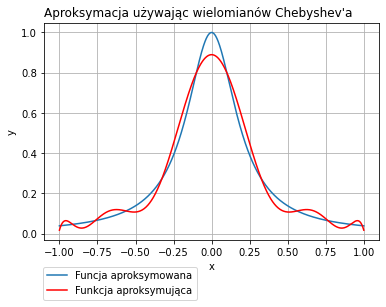

In [51]:
res, poly = approx_4(func, 10)
print(res)
plot_res(func, poly, "Aproksymacja używając wielomianów Chebyshev'a")

### 4.5. Aproksymacja ciągła używając wielomianów Chebyshev'a i wzoru Clenshawa

In [52]:
def approx_4b(func, deg):
    
    def Chebyshev(n):
        if n == 0:
            return 1

        if n == 1:
            return x

        return 2 * x * Chebyshev(n-1) -  Chebyshev(n-2)
    
    def c_k(k, f):
        # korzystając z otogonalności
        # <Φ(k), Φ(k)> = π/2 , k != 0
        # <Φ(k), Φ(k)> = π , k = 0
        # <f, Φ(k)> - trzeba policzyć
        
        factor = math.pi
        if k!=0:
            factor /= 2
            
        w = 1/sqrt(1 - x**2)
    
        return 1/factor * quad(lambdify(x, w * f * Chebyshev(k)), -1, 1)[0]
    
    @lru_cache(maxsize=None)
    def y_k(k, f):
        if k == deg + 1 or k == deg+2:
            return 0
        return 2*x*y_k(k+1, f) - y_k(k+2, f) + c_k(k, f)
    
        
    res = -1* y_k(2, func) + y_k(1, func) * x + c_k(0, func)
        
    return simplify(res), lambdify(x, res)

-27.5367763506826*x**10 + 79.0850816904484*x**8 - 84.5332274121082*x**6 + 41.4497411760024*x**4 - 9.33774680992083*x**2 + 0.889771695700361


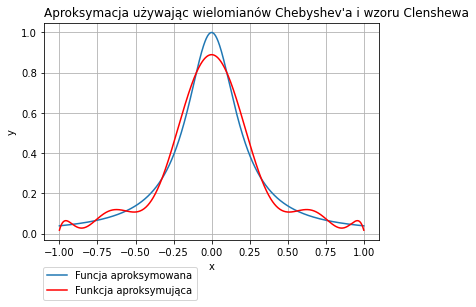

In [53]:
res, poly = approx_4b(func, 10)
print(res)
plot_res(func, poly, "Aproksymacja używając wielomianów Chebyshev'a i wzoru Clenshewa")